In [1]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

In [2]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0

def make_riverSwim(epLen=20, nState=5):
    '''
    Makes the benchmark RiverSwim MDP.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (5/1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = 0.3
        P_true[s, 1][s] = 0.6
        P_true[s, 1][max(0, s-1)] = 0.1

    P_true[0, 1][0] = 0.3
    P_true[0, 1][1] = 0.7
    P_true[nState - 1, 1][nState - 1] = 0.9
    P_true[nState - 1, 1][nState - 2] = 0.1

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.states = states
    riverSwim.reset()

    return riverSwim

class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState

    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0

    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])

        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd

    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [9]:
class UC_MatrixRL(object):
    def __init__(self,env,N):
        self.env = env
        #See Step 3 of Algorithm 1
        self.N = N
        #The dimensionality of phi(s,a), see Step 2 or Assumption 1
        self.d1 = self.env.nState * self.env.nAction
        #The dimensionality of psi(s'), see Step 2 or Assumption 1
        self.d2 = self.env.nState
        #Step 2
        self.features_state_action = {(s,a): np.zeros(self.d1) for s in self.env.states.keys() for a in range(self.env.nAction)}
        #Step 3
        self.features_next_state = {(s): np.zeros(self.d2) for s in self.env.states.keys()}
        # A hack for using numpy's linear algebra functions in Step 4
        self.features_next_state_mat = np.identity(self.d2)
        # Creates the Identity Matrix for a dictionary
        self.createIdentity()
        # Initialize our Q matrix
        self.Q = {(h,s,a): 0.0 for h in range(self.env.epLen) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        #Step 4
        self.A = np.identity(self.d1)
        #For use in the Sherman-Morrison Update
        self.Ainv = np.linalg.inv(self.A)
        #Step 4
        self.M = np.zeros((self.d1,self.d2))
        #See Assumptions 2,2' and Theorem 1, this equals 1 in the tabular case
        self.C_phi = 1.0
        # See Assumption 2'(Stronger Feature Regularity), and consider the case when v_1 = v_2 = ....
        self.C_psi = np.sqrt(env.nState)
        # See Theorem 1
        self.C_M = 1.0
        # See Theorem 1
        self.C_psi_ = 1.0
        # This value scales our confidence interval, must be > 0
        self.c = 1.0
        # For use in updating M_n, see Step 13 and Eqn (2)
        self.sums = np.zeros((self.d1,self.d2))
        #Creates K_psi, see Section 3.1: Estimating the core matrix.
        self.createK()

    def createK(self):
        '''
        A function that creates K_psi and (K_psi)^-1 for use in the Sherman-Morrison Update
        See Section 3.1: Estimating the core matrix
        '''
        self.K = np.zeros((self.d2,self.d2))
        for s_ in self.env.states.keys():
            self.K = self.K + np.outer(self.features_next_state[s_],self.features_next_state[s_])
        self.Kinv = np.linalg.inv(self.K)

    def act(self,s,h):
        '''
        A function that returns the argmax of Q given the state and timestep
        '''
        return self.env.argmax(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))

    def createIdentity(self):
        '''
            A function that creates the Identity Matrix for a Dictionary
        '''
        i = 0
        for key in self.features_state_action.keys():
            self.features_state_action[key][i] = 1
            i += 1
        j = 0
        for key in self.features_next_state.keys():
            self.features_next_state[key][j] = 1
            j += 1

    def proj(self, x, lo, hi):
        '''Projects the value of x into the [lo,hi] interval'''
        return max(min(x,hi),lo)

    def compute_Q(self,n):
        '''
        A function that computes the Optimisic Q-Values, see step 6 and Equations 4,8.
        '''
        Q = {(h,s,a): 0.0 for h in range(self.env.epLen) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        V = {h: np.zeros(self.env.nState) for h in range(self.env.epLen + 1)}
        for h in range(self.env.epLen-1,-1,-1):
            for s in self.env.states.keys():
                for a in range(self.env.nAction):
                    r = self.env.R[s,a][0]

                    value = np.dot(np.matmul(np.dot(self.features_state_action[s,a].T,self.M),\
                            self.features_next_state_mat),V[h+1])

                    bonus = 2 * self.C_psi * np.sqrt(self.Beta(n)) * np.dot(\
                            np.dot(self.features_state_action[s,a],self.Ainv),self.features_state_action[s,a])

                    Q[h,s,a] = self.proj(r+value+bonus,0,self.env.epLen)
                V[h][s] = max(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
        self.Q = Q.copy()

    def Beta(self,n):
        '''
        A function that computes Beta under the Assumption Theorem 2 holds, see equation 8
        '''
        first = self.c*(self.C_M * self.C_psi_ ** 2)
        second = np.log(self.N*self.env.epLen*self.C_phi)*self.d1
        #The line of code below for an anytime version
        #second = np.log(n*self.env.epLen*self.C_phi)*self.d1
        return first * second

    def update_core_matrix(self,s,a,s_):
        '''
        A function that performs step 12 and 13.
        '''
        self.A = self.A + np.outer(self.features_state_action[s,a],self.features_state_action[s,a])

        self.Ainv = self.Ainv - np.dot((np.outer(np.dot(self.Ainv,self.features_state_action[s,a]) \
                 ,self.features_state_action[s,a])),self.Ainv) / \
                    (1 + np.dot(np.dot(self.features_state_action[s,a],self.Ainv),self.features_state_action[s,a]))

        self.sums = self.sums + np.outer(self.features_state_action[s,a],self.features_next_state[s_])

        self.M = np.matmul(np.matmul(self.Ainv,self.sums),self.Kinv)

In [10]:
env = make_riverSwim(epLen = 20, nState = 4)
N = 500
agent = UC_MatrixRL(env,N)
R = 0
Rvec = []

In [11]:
for n in tqdm(range(1,N+1)):
    env.reset()
    done = 0
    agent.compute_Q(n)
    while not done:
        s = env.state
        h = env.timestep
        a = agent.act(s,h)
        r,s_,done = env.advance(a)
        R += r
        agent.update_core_matrix(s,a,s_)
    Rvec.append(R)

In [12]:
true_p = []
for values in env.P.values():
    for value in values:
        true_p.append(value)
        
estimated_p = []
for values in agent.M:
    for value in values:
        estimated_p.append(value)
        
print('The 2-norm of (True Transition Probabiltites - Estimated Probabilities) is:',np.linalg.norm(np.subtract(true_p,estimated_p)))

The 2-norm of (True Transition Probabiltites - Estimated Probabilities) is: 0.035413304627845


In [13]:
agent.M

array([[0.99642857, 0.        , 0.        , 0.        ],
       [0.29760766, 0.70143541, 0.        , 0.        ],
       [0.99411765, 0.        , 0.        , 0.        ],
       [0.09753788, 0.60179924, 0.30018939, 0.        ],
       [0.        , 0.99305556, 0.        , 0.        ],
       [0.        , 0.09201077, 0.59605027, 0.31149013],
       [0.        , 0.        , 0.97142857, 0.        ],
       [0.        , 0.        , 0.10741112, 0.89233851]])

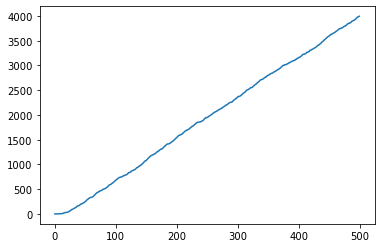

In [14]:
plt.plot(Rvec)